<a href="https://colab.research.google.com/github/dev-vickie/fawlpox/blob/main/chicken.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from PIL import Image, UnidentifiedImageError
import numpy as np
import secrets
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


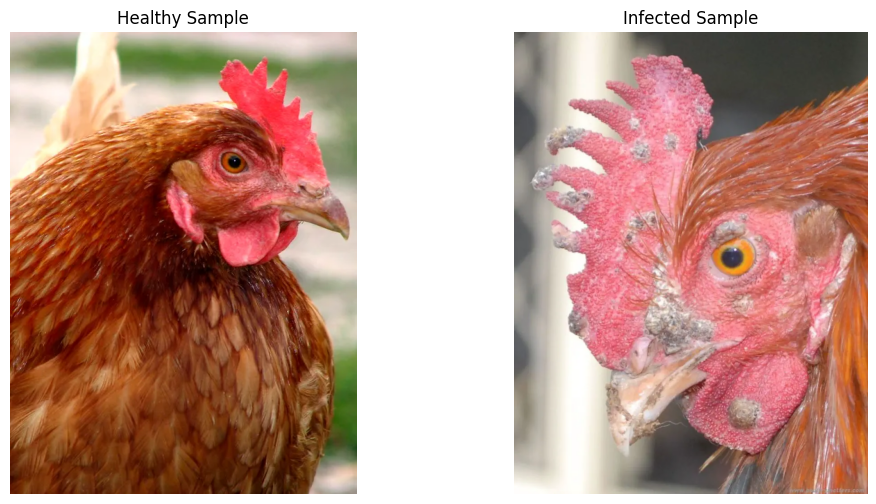

In [ ]:



healthy_path = os.path.join(os.path.join(parent_path, 'data_folder'), 'healthy')
infected_path = os.path.join(os.path.join(parent_path, 'data_folder'), 'infected')

# Visualize a healthy sample image
healthy_sample_path = os.path.join(healthy_path, os.listdir(healthy_path)[0])
healthy_sample_img = mpimg.imread(healthy_sample_path)

# Visualize an infected sample image
infected_sample_path = os.path.join(infected_path, os.listdir(infected_path)[0])
infected_sample_img = mpimg.imread(infected_sample_path)

# Plot side by side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(healthy_sample_img)
plt.title('Healthy Sample')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(infected_sample_img)
plt.title('Infected Sample')
plt.axis('off')

plt.show()


In [ ]:
#include file paths

parent_path = r"/content/drive/MyDrive/data/chicken1"
parent_path1 = os.path.join(parent_path,'data_folder')
path = os.path.join(os.path.join(parent_path, 'data_folder'),'healthy')
path1 = os.path.join(os.path.join(parent_path, 'data_folder'),'infected')
model_path = os.path.join(os.path.join(parent_path, 'chicken_model'),'chicken_predictor.h5')
test_data = os.path.join(parent_path, 'test_data')

In [ ]:
#Image Processing
def filter_img(scaled_img):
    boxblurred_img_5 = scaled_img.filter(ImageFilter.BoxBlur(5))
    boxblurred_img_20 = scaled_img.filter(ImageFilter.BoxBlur(20))
    gaussianblurred_img = scaled_img.filter(ImageFilter.GaussianBlur(20))
    return boxblurred_img_5,boxblurred_img_20,gaussianblurred_img

def scale_img(raw_img):
    with Image.open(raw_img) as img:
        raw_img = img.load()
        transposed_img = raw_img.transpose(Image.FLIP_TOP_BOTTOM)
        img1,img2,img3 = filter_img(transposed_img)
        rotated_img = raw_img.rotate(45,expand=True)
        img4,img5,img6 = filter_img(rotated_img)
    return [img1,img2,img3,img4,img5,img6]

In [ ]:
#function predicts images from test data for health status

def predict_image_state(image_path, model):
    try:
        if os.path.exists(image_path):
            img = Image.open(image_path)
            img = img.resize((128, 128))
            img = np.array(img) / 255.0
            img = np.expand_dims(img, axis=0)

            prediction = model.predict(img)

            if prediction[0][0] > 0.5:
                return "Infected"
            else:
                return "Healthy"
    except (UnidentifiedImageError, OSError):
        os.remove(image_path)

In [ ]:
#images are resized to a 128 by 128 dimenion before used to make a model

def resize_image(input_image_path, output_image_path, target_size):
    try:
        image = Image.open(input_image_path)
        if image.size[0] == 0 or image.size[1] == 0:
            return
        if image.mode == 'RGBA':
            image = image.convert('RGB')
        resized_image = image.resize(target_size)
        resized_image.save(output_image_path)
    except (UnidentifiedImageError, OSError):
        os.remove(input_image_path)

In [ ]:
#function creates a model using CNN from tf

def create_and_train_cnn(data_directory=r"/content/drive/MyDrive/data/chicken1/data_folder",target_size=(128, 128), epochs=20):
    img_list = []
    for subdir in os.listdir(data_directory):
        for item in os.listdir(os.path.join(data_directory,subdir)):
            if item.endswith(('.jpg', '.png', '.jpeg')):
                if item.endswith('.jpg'):
                    img_list = scale_img(item)
                    for identifier,created_img in enumerate(img_list):
                        created_img.save(os.path.join(os.path.join(data_directory,subdir),f'{identifier}.jpg'))


                if item.endswith('.png'):
                    img_list = scale_img(item)
                    for identifier,created_img in enumerate(img_list):
                        created_img.save(os.path.join(os.path.join(data_directory,subdir),f'{identifier}.png'))


                if item.endswith('.jpeg'):
                    img_list = scale_img(item)
                    for identifier,created_img in enumerate(img_list):
                        created_img.save(os.path.join(os.path.join(data_directory,subdir),f'{identifier}.jpeg'))

                file_path = os.path.join(os.path.join(data_directory, subdir),item)
                resize_image(file_path, file_path, target_size)

    for subdir in os.listdir(data_directory):
        for item in os.listdir(os.path.join(data_directory,subdir)):
            if item.endswith(('.jpg', '.png', '.jpeg')):
                file_path = os.path.join(os.path.join(data_directory, subdir),item)
                resize_image(file_path, file_path, target_size)
#use of the image generator
    train_data_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        vertical_flip=True,
        brightness_range=[0.5, 1.5]
    )

    train_data = train_data_gen.flow_from_directory(
        data_directory,
        target_size=target_size,
        batch_size=32,
        class_mode='binary',
        subset="training"
    )

    validation_data_gen = ImageDataGenerator(rescale=1./255)

    validation_data = validation_data_gen.flow_from_directory(
        data_directory,
        target_size=target_size,
        batch_size=32,
        class_mode='binary',
        subset="validation"
    )

    model = keras.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

    model.fit(
        train_data,
        epochs=epochs,
        validation_data=validation_data,
        steps_per_epoch=len(train_data),
        validation_steps=len(validation_data),
        callbacks=[lr_scheduler]
    )

    model.save(model_path)
    return model
#query to train a new model or continue with a precreated model

if input('Train Data? [y/n] ').lower() == 'y':
    trained_model = create_and_train_cnn()
else:
    trained_model = load_model(model_path)
    #loop through each picture in test data and rename it to a 16 bit value

for item in os.listdir(test_data):
    image_path = os.path.join(test_data, item)
    os.rename(image_path,os.path.join(test_data, f'{secrets.token_urlsafe(16)}.jpg'))


Train Data? [y/n] n


In [ ]:
def train_predict():
  if input('Train Data? [y/n] ').lower() == 'y':
      trained_model = create_and_train_cnn()
  else:
      trained_model = load_model(model_path)

  #loop through each picture in test data and rename it to a 16 bit value

  for item in os.listdir(test_data):
      image_path = os.path.join(test_data, item)
      os.rename(image_path,os.path.join(test_data, f'{secrets.token_urlsafe(16)}.jpg'))

  #loop through the test data to predict each status of the picture and rename the picture to its status

  for index,image in enumerate(os.listdir(test_data)):
      image_path1 = os.path.join(test_data, image)
      image_code = predict_image_state(image_path1, trained_model)
      if os.path.exists(image_path1):
          print(f'{image} status: {image_code}')
          new_path = os.path.join(test_data, f'{image_code}[{index}].jpg')
          os.rename(image_path1, new_path)

In [ ]:
train_predict()

Train Data? [y/n] n
1/1 [==============================] - 0s 270ms/step
4FFPmf_OfVIpRGsAfqXyLA.jpg status: Healthy
1/1 [==============================] - 0s 48ms/step
jjnX26sGPtnKepUSX4K25w.jpg status: Healthy
1/1 [==============================] - 0s 45ms/step
eeGRAhjADYNePjBT2pjvoA.jpg status: Healthy
1/1 [==============================] - 0s 46ms/step
4NeBJtn8sqP87wCqsBoMog.jpg status: Infected
1/1 [==============================] - 0s 79ms/step
thIwk9rmK5Z8XBk3kjGfLg.jpg status: Infected
1/1 [==============================] - 0s 69ms/step
8Q64MIIyZcIUwMqMbJotMA.jpg status: Infected
1/1 [==============================] - 0s 76ms/step
nH8nisgIo0pSyPYCCPUfAw.jpg status: Healthy


In [ ]:
   #include file paths
  #wait

parent_path = r"/content/drive/MyDrive/data/chicken1"
parent_path1 = os.path.join(parent_path,'data_folder')
path = os.path.join(os.path.join(parent_path, 'data_folder'),'healthy')
path1 = os.path.join(os.path.join(parent_path, 'data_folder'),'infected')
model_path = os.path.join(os.path.join(parent_path, 'chicken_model'),'chicken_predictor.h5')
test_data = os.path.join(parent_path, 'test_data')

#function predicts images from test data for health status

def predict_image_state(image_path, model):
    try:
        if os.path.exists(image_path):
            img = Image.open(image_path)
            img = img.resize((128, 128))
            img = np.array(img) / 255.0
            img = np.expand_dims(img, axis=0)

            prediction = model.predict(img)

            if prediction[0][0] > 0.5:
                return "Infected"
            else:
                return "Healthy"
    except (UnidentifiedImageError, OSError):
        os.remove(image_path)

#images are resized to a 128 by 128 dimenion before used to make a model

def resize_image(input_image_path, output_image_path, target_size):
    try:
        image = Image.open(input_image_path)
        if image.size[0] == 0 or image.size[1] == 0:
            return
        if image.mode == 'RGBA':
            image = image.convert('RGB')
        resized_image = image.resize(target_size)
        resized_image.save(output_image_path)
    except (UnidentifiedImageError, OSError):
        os.remove(input_image_path)

#function creates a model using CNN from tf

def create_and_train_cnn(data_directory=r"/content/drive/MyDrive/data/chicken1/data_folder",target_size=(128, 128), epochs=20):
    for subdir in os.listdir(data_directory):
        for item in os.listdir(os.path.join(data_directory,subdir)):
            if item.endswith(('.jpg', '.png', '.jpeg')):
                file_path = os.path.join(os.path.join(data_directory, subdir),item)
                resize_image(file_path, file_path, target_size)
#use of the image generator
    train_data_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        vertical_flip=True,
        brightness_range=[0.5, 1.5]
    )

    train_data = train_data_gen.flow_from_directory(
        data_directory,
        target_size=target_size,
        batch_size=32,
        class_mode='binary',
        subset="training"
    )

    validation_data_gen = ImageDataGenerator(rescale=1./255)

    validation_data = validation_data_gen.flow_from_directory(
        data_directory,
        target_size=target_size,
        batch_size=32,
        class_mode='binary',
        subset="validation"
    )

    model = keras.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

    model.fit(
        train_data,
        epochs=epochs,
        validation_data=validation_data,
        steps_per_epoch=len(train_data),
        validation_steps=len(validation_data),
        callbacks=[lr_scheduler]
    )

    model.save(model_path)
    return model

#query to train a new model or continue with a precreated model

if input('Train Data? [y/n] ').lower() == 'y':
    trained_model = create_and_train_cnn()
else:
    trained_model = load_model(model_path)

#loop through each picture in test data and rename it to a 16 bit value

for item in os.listdir(test_data):
    image_path = os.path.join(test_data, item)
    os.rename(image_path,os.path.join(test_data, f'{secrets.token_urlsafe(16)}.jpg'))




Found 347 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 0.7248 - accuracy: 0.5043

11/11 [==============================] - 50s 4s/step - loss: 0.7248 - accuracy: 0.5043 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 0.6862 - accuracy: 0.5331

11/11 [==============================] - 37s 3s/step - loss: 0.6862 - accuracy: 0.5331 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 0.6702 - accuracy: 0.5965

11/11 [==============================] - 35s 3s/step - loss: 0.6702 - accuracy: 0.5965 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - ETA: 0s - loss: 0.6218 - accuracy: 0.6772

11/11 [==============================] - 36s 3s/step - loss: 0.6218 - accuracy: 0.6772 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - ETA: 0s - loss: 0.6081 - accuracy: 0.7262

11/11 [==============================] - 35s 3s/step - loss: 0.6081 - accuracy: 0.7262 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - ETA: 0s - loss: 0.6142 - accuracy: 0.7003

11/11 [==============================] - 35s 3s/step - loss: 0.6142 - accuracy: 0.7003 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - ETA: 0s - loss: 0.5820 - accuracy: 0.7435

11/11 [==============================] - 35s 3s/step - loss: 0.5820 - accuracy: 0.7435 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - ETA: 0s - loss: 0.5641 - accuracy: 0.7061

11/11 [==============================] - 36s 3s/step - loss: 0.5641 - accuracy: 0.7061 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - ETA: 0s - loss: 0.5932 - accuracy: 0.7205

11/11 [==============================] - 35s 3s/step - loss: 0.5932 - accuracy: 0.7205 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - ETA: 0s - loss: 0.5316 - accuracy: 0.7579

11/11 [==============================] - 36s 3s/step - loss: 0.5316 - accuracy: 0.7579 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - ETA: 0s - loss: 0.5874 - accuracy: 0.7089

11/11 [==============================] - 35s 3s/step - loss: 0.5874 - accuracy: 0.7089 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - ETA: 0s - loss: 0.5769 - accuracy: 0.7089

11/11 [==============================] - 35s 3s/step - loss: 0.5769 - accuracy: 0.7089 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - ETA: 0s - loss: 0.5792 - accuracy: 0.7262

11/11 [==============================] - 35s 3s/step - loss: 0.5792 - accuracy: 0.7262 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - ETA: 0s - loss: 0.5862 - accuracy: 0.7262

11/11 [==============================] - 35s 3s/step - loss: 0.5862 - accuracy: 0.7262 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - ETA: 0s - loss: 0.5183 - accuracy: 0.7493

11/11 [==============================] - 36s 3s/step - loss: 0.5183 - accuracy: 0.7493 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - ETA: 0s - loss: 0.5123 - accuracy: 0.7608

11/11 [==============================] - 35s 3s/step - loss: 0.5123 - accuracy: 0.7608 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - ETA: 0s - loss: 0.5370 - accuracy: 0.7637

11/11 [==============================] - 35s 3s/step - loss: 0.5370 - accuracy: 0.7637 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - ETA: 0s - loss: 0.4854 - accuracy: 0.7867

11/11 [==============================] - 36s 3s/step - loss: 0.4854 - accuracy: 0.7867 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - ETA: 0s - loss: 0.4783 - accuracy: 0.7608

11/11 [==============================] - 39s 3s/step - loss: 0.4783 - accuracy: 0.7608 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - ETA: 0s - loss: 0.4622 - accuracy: 0.8069

11/11 [==============================] - 38s 3s/step - loss: 0.4622 - accuracy: 0.8069 - lr: 0.0010


In [ ]:
def train_predict():
  if input('Train Data? [y/n] ').lower() == 'y':
      trained_model = create_and_train_cnn()
  else:
      trained_model = load_model(model_path)

  #loop through each picture in test data and rename it to a 16 bit value

  for item in os.listdir(test_data):
      image_path = os.path.join(test_data, item)
      os.rename(image_path,os.path.join(test_data, f'{secrets.token_urlsafe(16)}.jpg'))

  #loop through the test data to predict each status of the picture and rename the picture to its status

  for index,image in enumerate(os.listdir(test_data)):
      image_path1 = os.path.join(test_data, image)
      image_code = predict_image_state(image_path1, trained_model)
      if os.path.exists(image_path1):
          print(f'{image} status: {image_code}')
          new_path = os.path.join(test_data, f'{image_code}[{index}].jpg')
          os.rename(image_path1, new_path)

In [ ]:
train_predict()

Train Data? [y/n] n
1/1 [==============================] - 0s 268ms/step
Eq0dKtBg6oJkQw_zfrbrDg.jpg status: Healthy
1/1 [==============================] - 0s 82ms/step
_epXO04mjG47VxFP8oWChw.jpg status: Healthy
1/1 [==============================] - 0s 72ms/step
QaBudujcsPOHG9RsHT5X9Q.jpg status: Healthy
1/1 [==============================] - 0s 49ms/step
vqqCA6cJdos9j3GRfONo-Q.jpg status: Infected
1/1 [==============================] - 0s 48ms/step
hjJiwJP6KRWekEZCARIWcQ.jpg status: Infected
1/1 [==============================] - 0s 46ms/step
Y22Cra1dTTjQH4K6qCVHjA.jpg status: Infected
